<a href="https://colab.research.google.com/github/alexandre-pinon/zoidberg-2.0/blob/main/zoidberg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zoidberg 2.0 - Binary classification

**Given some X-ray images, use machine learning to help doctors detecting pneumonia.**

## Notebook Config

In [ ]:
DATASET_DIR = "/content/zoidberg-2.0/chest_Xray_binary"
SEED = 2
IMG_SIZE = 224, 224
BATCH_SIZE = 32

In [ ]:
import os
import pathlib
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Load data

In [ ]:
!git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

Cloning into 'zoidberg-2.0'...
remote: Enumerating objects: 5913, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 5913 (delta 3), reused 9 (delta 1), pack-reused 5902
Receiving objects: 100% (5913/5913), 1.14 GiB | 28.09 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (11712/11712), done.


## Inspect data

In [ ]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(DATASET_DIR):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/val'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_binary/val/pneumonia'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_binary/val/normal'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/train'.
There are 0 directories and 3875 images in '/content/zoidberg-2.0/chest_Xray_binary/train/pneumonia'.
There are 0 directories and 1341 images in '/content/zoidberg-2.0/chest_Xray_binary/train/normal'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_binary/test'.
There are 0 directories and 390 images in '/content/zoidberg-2.0/chest_Xray_binary/test/pneumonia'.
There are 0 directories and 234 images in '/content/zoidberg-2.0/chest_Xray_binary/test/normal'.


In [ ]:
train_dir = f"{DATASET_DIR}/train/"
val_dir = f"{DATASET_DIR}/val/"
test_dir = f"{DATASET_DIR}/test/"

In [ ]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['normal' 'pneumonia']


In [8]:
def view_random_images(target_dir, class_names):
  n_images = 10
  fig, ax = plt.subplots(2, 5, figsize=(24, 8))

  # Read in the image and plot it using matplotlib
  for i in range(n_images):
    target_class = random.choice(class_names)
    target_folder = target_dir + target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)[0]

    index = (0, i) if i < 5 else (1, i - 5)
    img = mpimg.imread(f'{target_folder}/{random_image}')
    ax[index].imshow(img, cmap='bone')
    ax[index].set_title(target_class)
    ax[index].set_frame_on(False)
    ax[index].set_xticks([])
    ax[index].set_yticks([])
    ax[index].set_xlabel(f"{img.shape}")

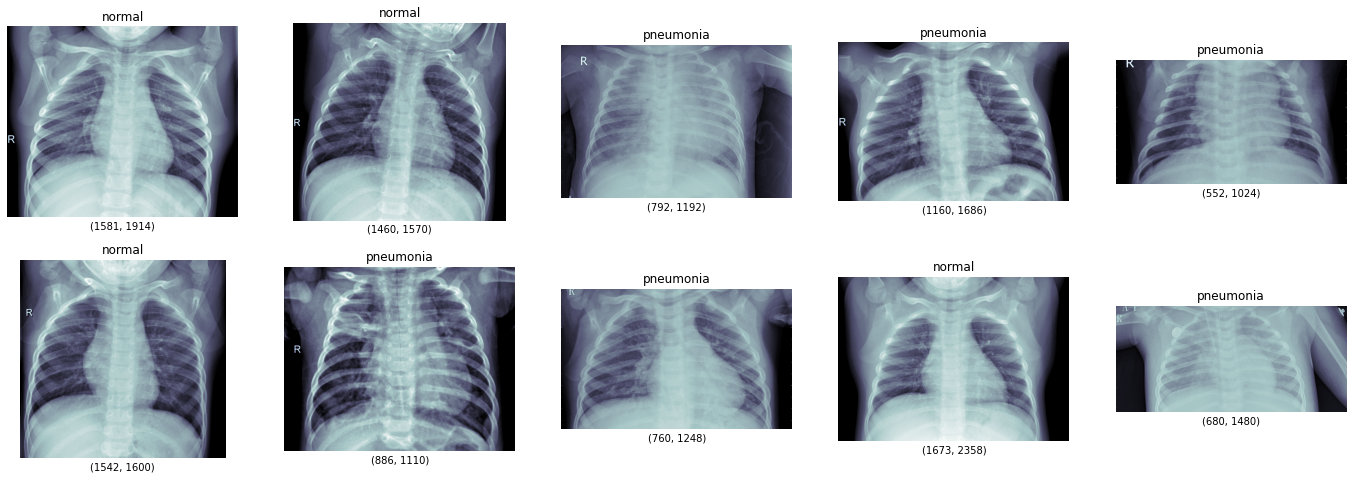

In [ ]:
# View a random image from the training dataset
img = view_random_images(target_dir=train_dir,
                         class_names=class_names)

## Preprocess data

In [ ]:
# Create train and test data generators and rescale the data 
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')

val_data = train_datagen.flow_from_directory(directory=train_dir,
                                           target_size=IMG_SIZE,
                                           class_mode='binary',
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           seed=SEED,
                                           subset='validation')

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='binary',
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Create baseline model

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_1 = Sequential([
  Flatten(input_shape=(*IMG_SIZE, 3)),
  Dense(4, activation='relu'),
  Dense(1, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_1.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 56s 422ms/step - loss: 0.6794 - accuracy: 0.7400 - val_loss: 0.6658 - val_accuracy: 0.7430
Epoch 2/5
131/131 [==============================] - 55s 418ms/step - loss: 0.6544 - accuracy: 0.7429 - val_loss: 0.6435 - val_accuracy: 0.7430
Epoch 3/5
131/131 [==============================] - 55s 418ms/step - loss: 0.6341 - accuracy: 0.7429 - val_loss: 0.6252 - val_accuracy: 0.7430
Epoch 4/5
131/131 [==============================] - 55s 420ms/step - loss: 0.6183 - accuracy: 0.7429 - val_loss: 0.6114 - val_accuracy: 0.7430
Epoch 5/5
131/131 [==============================] - 55s 422ms/step - loss: 0.6059 - accuracy: 0.7429 - val_loss: 0.6008 - val_accuracy: 0.7430


In [ ]:
model_1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 150528)            0         
                                                                 
 dense_21 (Dense)            (None, 4)                 602116    
                                                                 
 dense_22 (Dense)            (None, 1)                 5         
                                                                 
 dense_23 (Dense)            (None, 1)                 2         
                                                                 
Total params: 602,123
Trainable params: 602,123
Non-trainable params: 0
_________________________________________________________________


## Evaluate model

In [9]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  # Plot loss
  ax[0].plot(epochs, loss, label='training_loss', c='r')
  ax[0].plot(epochs, val_loss, label='val_loss', c='orange')
  ax[0].set_title('Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].legend()

  # Plot accuracy
  ax[1].plot(epochs, accuracy, label='training_accuracy', c='g')
  ax[1].plot(epochs, val_accuracy, label='val_accuracy', c='lightgreen')
  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].legend()

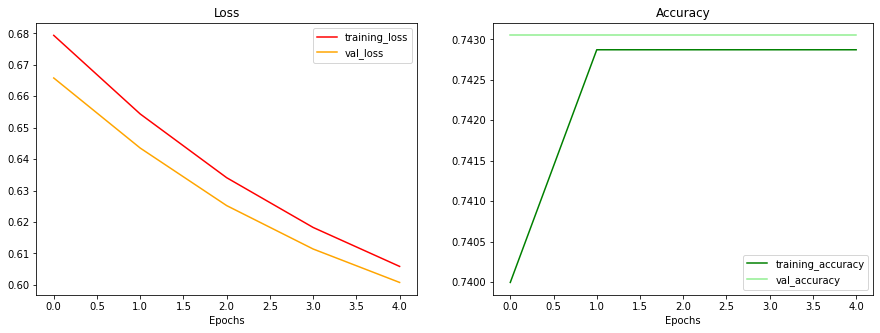

In [ ]:
plot_loss_curves(history_1)

In [ ]:
def evaluate_model(model, test_data):
  y_pred = model.predict(test_data)
  y_pred = np.round(y_pred.flatten())
  print(f'Accuracy: {accuracy_score(test_data.labels, y_pred):.1%}')
  print(f"Precision: {precision_score(test_data.labels, y_pred):.1%}")
  print(f"Recall: {recall_score(test_data.labels, y_pred):.1%}")
  print(f"F1: {f1_score(test_data.labels, y_pred):.1%}")

In [ ]:
evaluate_model(model_1, test_data)

Model loss 0.7
Model accuracy 62.5%


## Adjust the model parameters

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_2 = Sequential([
  Flatten(input_shape=(*IMG_SIZE, 3)),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(100, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 56s 426ms/step - loss: 1.9145 - accuracy: 0.8088 - val_loss: 0.3562 - val_accuracy: 0.8754
Epoch 2/5
131/131 [==============================] - 54s 417ms/step - loss: 0.2811 - accuracy: 0.9058 - val_loss: 0.1864 - val_accuracy: 0.9348
Epoch 3/5
131/131 [==============================] - 55s 419ms/step - loss: 0.3014 - accuracy: 0.9104 - val_loss: 0.2078 - val_accuracy: 0.9271
Epoch 4/5
131/131 [==============================] - 55s 418ms/step - loss: 0.1824 - accuracy: 0.9384 - val_loss: 0.2621 - val_accuracy: 0.9003
Epoch 5/5
131/131 [==============================] - 55s 420ms/step - loss: 0.1318 - accuracy: 0.9521 - val_loss: 0.1645 - val_accuracy: 0.9358


In [ ]:
plot_loss_curves(history_2)

In [ ]:
evaluate_model(model_2, test_data)

Model loss 0.7
Model accuracy 77.9%


## Making a prediction

In [ ]:
def make_val_predictions(model, class_names):
  # Import the target images and preprocess them
  plot_datagen = ImageDataGenerator(rescale=1/255.)
  plot_data = plot_datagen.flow_from_directory(directory=val_dir,
                                                target_size=IMG_SIZE,
                                                class_mode='binary',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                seed=SEED)
  # Make predictions
  preds = model.predict(plot_data).flatten()

  # Get predictions labels & percentages
  percentages = []
  preds_labels = []
  true_labels = class_names[plot_data.labels]

  for pred in preds:
    percentages.append(pred if pred >= 0.5 else 1 - pred)
    preds_labels.append(class_names[int(tf.round(pred))])

  img_paths = plot_data.filepaths
  n_images = len(preds)
  n_rows = n_cols = (n_images // 4)
  fig, axes = plt.subplots(n_rows,
                           n_cols,
                           figsize=(4 * n_cols, 3 * n_rows),
                           gridspec_kw={'wspace': 0, 'hspace': .6})
  axes = np.ravel(axes)

  for i, ax in enumerate(axes):
    if i == n_images:
      break

    img = mpimg.imread(img_paths[i])
    color = 'green' if preds_labels[i] == true_labels[i] else 'red'

    ax.imshow(img, cmap='bone')
    ax.set_title(f"Pred: {preds_labels[i]} {percentages[i]:.1%}\n(True: {true_labels[i]})", c=color)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

Found 16 images belonging to 2 classes.


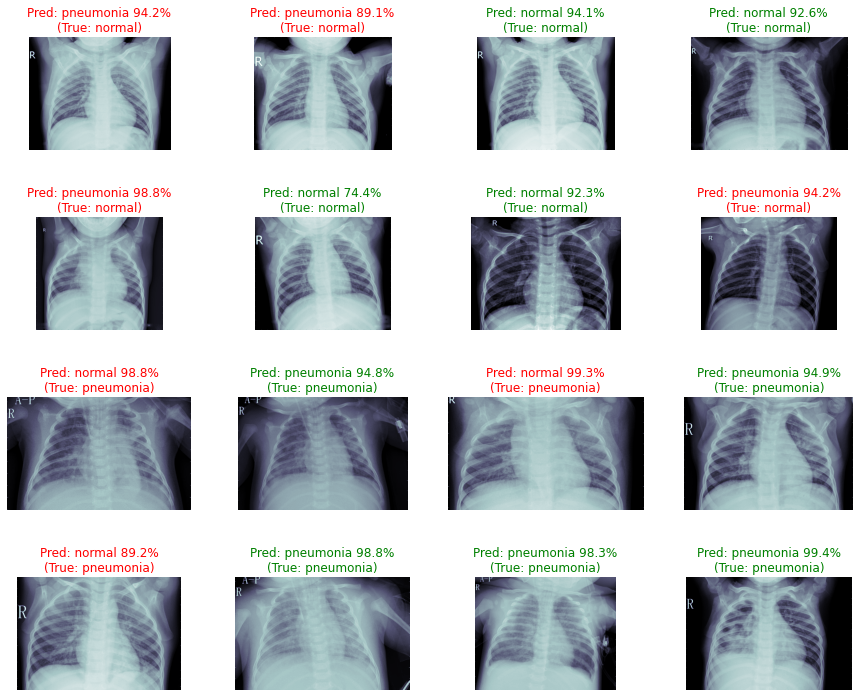

In [ ]:
make_val_predictions(model_2, class_names)

In [ ]:
make_val_predictions(model_1, class_names)

Found 16 images belonging to 2 classes.


## CNN

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_3 = Sequential([
  Conv2D(filters=10, # filter is the number of sliding windows going accross the input (higher = more complex model)
         kernel_size=3, # the size of the window going accross an input
         strides=1, # the size of the step the sliding window takes accross an input
         padding='valid', # if "same", output shape is same as input shape, if "valid", output shape gets compressed
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

# Compile the model
model_3.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 78s 511ms/step - loss: 0.4269 - accuracy: 0.8905 - val_loss: 0.1553 - val_accuracy: 0.9329
Epoch 2/5
131/131 [==============================] - 62s 472ms/step - loss: 0.0829 - accuracy: 0.9700 - val_loss: 0.1135 - val_accuracy: 0.9588
Epoch 3/5
131/131 [==============================] - 61s 466ms/step - loss: 0.0416 - accuracy: 0.9851 - val_loss: 0.1798 - val_accuracy: 0.9415
Epoch 4/5
131/131 [==============================] - 62s 471ms/step - loss: 0.0443 - accuracy: 0.9847 - val_loss: 0.2092 - val_accuracy: 0.9377
Epoch 5/5
131/131 [==============================] - 63s 479ms/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.1885 - val_accuracy: 0.9549


Model loss 2.6
Model accuracy 72.4%
Found 16 images belonging to 2 classes.


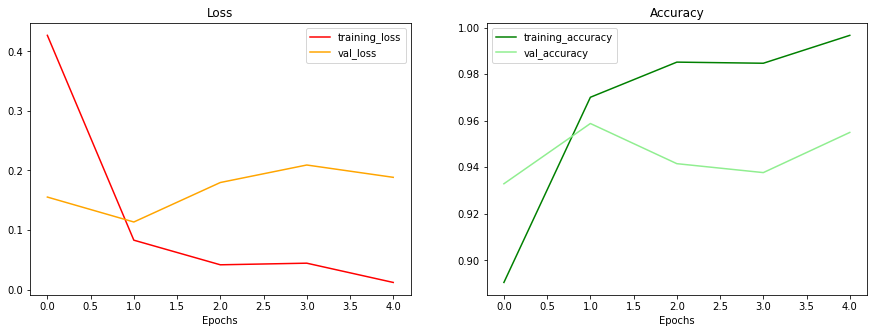

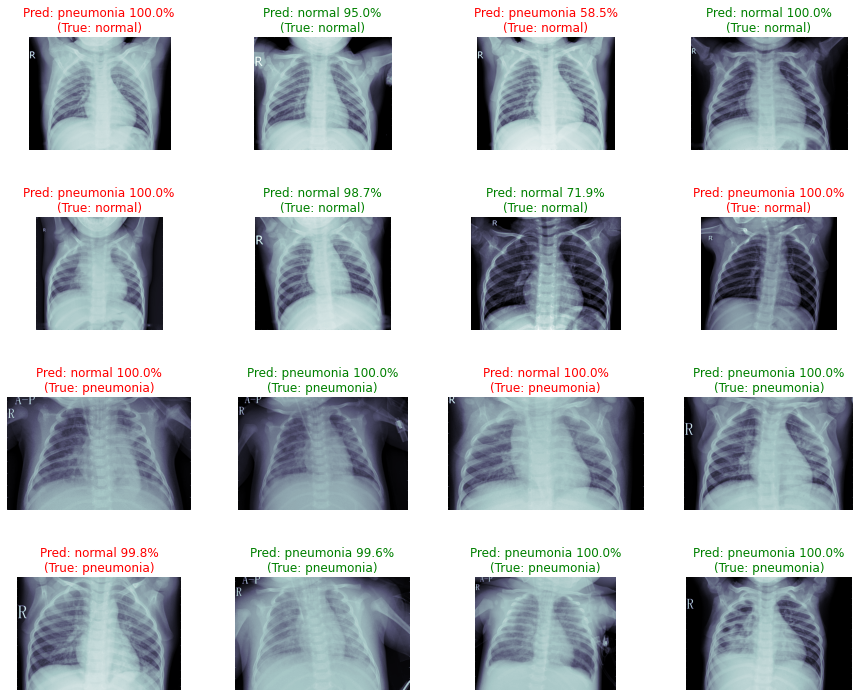

In [ ]:
plot_loss_curves(history_3)
evaluate_model(model_3, test_data)
make_val_predictions(model_3, class_names)

### Tiny VGG

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_4 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_4.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 69s 446ms/step - loss: 0.3091 - accuracy: 0.8677 - val_loss: 0.1565 - val_accuracy: 0.9444
Epoch 2/5
131/131 [==============================] - 58s 442ms/step - loss: 0.1025 - accuracy: 0.9641 - val_loss: 0.1807 - val_accuracy: 0.9262
Epoch 3/5
131/131 [==============================] - 58s 442ms/step - loss: 0.0865 - accuracy: 0.9696 - val_loss: 0.1038 - val_accuracy: 0.9645
Epoch 4/5
131/131 [==============================] - 60s 461ms/step - loss: 0.0883 - accuracy: 0.9679 - val_loss: 0.1222 - val_accuracy: 0.9540
Epoch 5/5
131/131 [==============================] - 60s 455ms/step - loss: 0.0558 - accuracy: 0.9823 - val_loss: 0.1303 - val_accuracy: 0.9559


In [ ]:
plot_loss_curves(history_4)
evaluate_model(model_4, test_data)
make_val_predictions(model_4, class_names)

Model loss 1.0
Model accuracy 77.7%
Found 16 images belonging to 2 classes.


In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_5 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_5.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 69s 508ms/step - loss: 0.3068 - accuracy: 0.8711 - val_loss: 0.1531 - val_accuracy: 0.9348
Epoch 2/5
131/131 [==============================] - 63s 483ms/step - loss: 0.1474 - accuracy: 0.9437 - val_loss: 0.1760 - val_accuracy: 0.9300
Epoch 3/5
131/131 [==============================] - 65s 497ms/step - loss: 0.0853 - accuracy: 0.9693 - val_loss: 0.1808 - val_accuracy: 0.9377
Epoch 4/5
131/131 [==============================] - 65s 495ms/step - loss: 0.0781 - accuracy: 0.9700 - val_loss: 0.1221 - val_accuracy: 0.9473
Epoch 5/5
131/131 [==============================] - 65s 493ms/step - loss: 0.0654 - accuracy: 0.9763 - val_loss: 0.1084 - val_accuracy: 0.9569


Model loss 1.3
Model accuracy 74.0%
Found 16 images belonging to 2 classes.


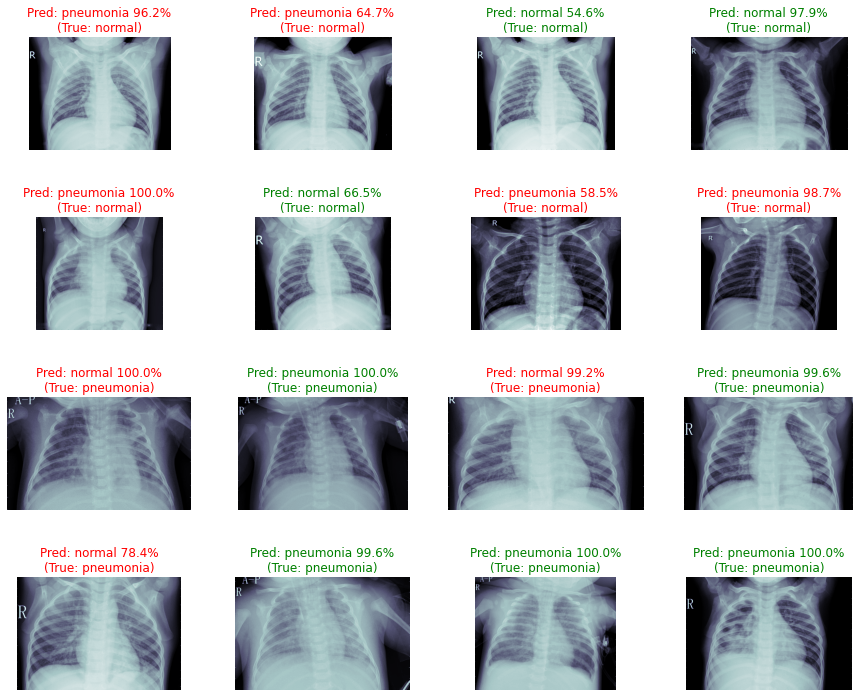

In [ ]:
plot_loss_curves(history_5)
evaluate_model(model_5, test_data)
make_val_predictions(model_5, class_names)

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_6 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_6 = model_6.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 61s 462ms/step - loss: 0.3815 - accuracy: 0.8370 - val_loss: 0.3109 - val_accuracy: 0.8725
Epoch 2/5
131/131 [==============================] - 62s 474ms/step - loss: 0.1405 - accuracy: 0.9451 - val_loss: 0.1485 - val_accuracy: 0.9444
Epoch 3/5
131/131 [==============================] - 60s 457ms/step - loss: 0.1087 - accuracy: 0.9590 - val_loss: 0.2184 - val_accuracy: 0.9185
Epoch 4/5
131/131 [==============================] - 59s 455ms/step - loss: 0.0900 - accuracy: 0.9672 - val_loss: 0.1427 - val_accuracy: 0.9425
Epoch 5/5
131/131 [==============================] - 59s 454ms/step - loss: 0.0807 - accuracy: 0.9710 - val_loss: 0.1209 - val_accuracy: 0.9521


Model loss 1.0
Model accuracy 74.0%
Found 16 images belonging to 2 classes.


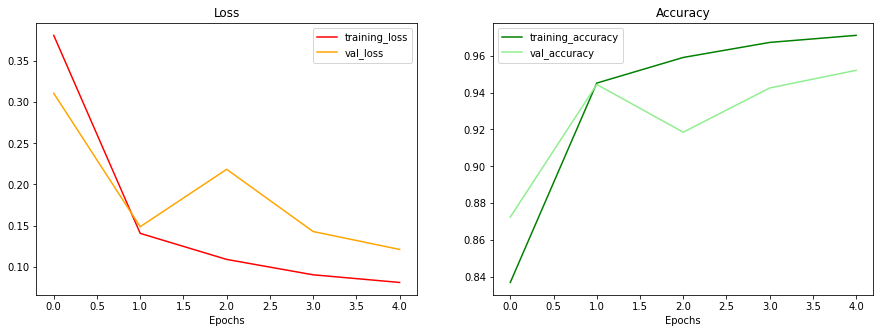

In [ ]:
plot_loss_curves(history_6)
evaluate_model(model_6, test_data)
make_val_predictions(model_6, class_names)

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_7 = Sequential([
  Conv2D(100, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(100, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_7 = model_7.fit(train_data,
                        epochs=5,
                        validation_data=val_data) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 95s 713ms/step - loss: 0.3893 - accuracy: 0.8308 - val_loss: 0.2900 - val_accuracy: 0.8859
Epoch 2/5
131/131 [==============================] - 94s 715ms/step - loss: 0.1398 - accuracy: 0.9504 - val_loss: 0.1708 - val_accuracy: 0.9463
Epoch 3/5
131/131 [==============================] - 94s 716ms/step - loss: 0.0903 - accuracy: 0.9660 - val_loss: 0.1672 - val_accuracy: 0.9415
Epoch 4/5
131/131 [==============================] - 94s 715ms/step - loss: 0.0626 - accuracy: 0.9768 - val_loss: 0.1395 - val_accuracy: 0.9530
Epoch 5/5
131/131 [==============================] - 94s 714ms/step - loss: 0.0472 - accuracy: 0.9830 - val_loss: 0.1653 - val_accuracy: 0.9492


Model loss 1.5
Model accuracy 72.9%
Found 16 images belonging to 2 classes.


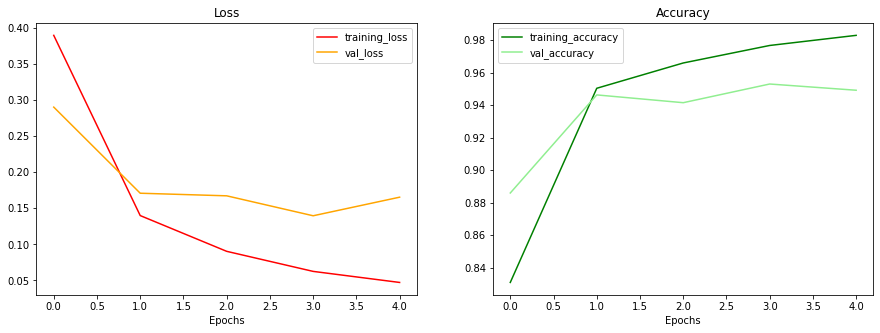

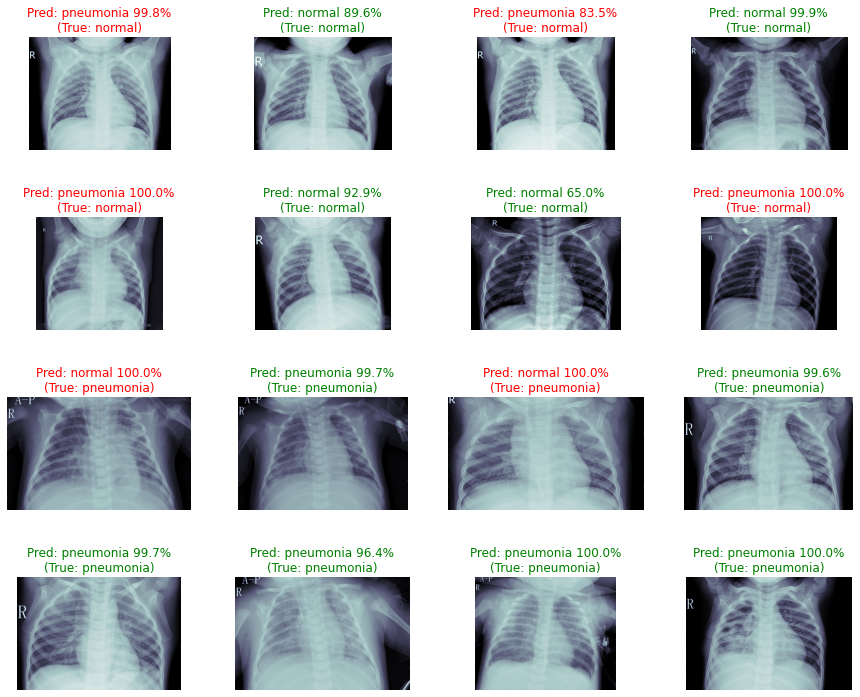

In [ ]:
plot_loss_curves(history_7)
evaluate_model(model_7, test_data)
make_val_predictions(model_7, class_names)

### Augmented Data

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True, # flip the image on the horizontal axis
                                             validation_split=0.2) 

# Turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                               target_size=IMG_SIZE,
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=SEED,
                                               subset='training')

val_data_augmented = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                           target_size=IMG_SIZE,
                                           class_mode='binary',
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           seed=SEED,
                                           subset='validation')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_8.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_8 = model_8.fit(train_data_augmented,
                        epochs=5,
                        validation_data=val_data_augmented) # fraction of the training data to be used as validation data

Epoch 1/5
131/131 [==============================] - 126s 870ms/step - loss: 0.4409 - accuracy: 0.7925 - val_loss: 0.3048 - val_accuracy: 0.8600
Epoch 2/5
131/131 [==============================] - 112s 858ms/step - loss: 0.3286 - accuracy: 0.8596 - val_loss: 0.3257 - val_accuracy: 0.8629
Epoch 3/5
131/131 [==============================] - 112s 854ms/step - loss: 0.3024 - accuracy: 0.8687 - val_loss: 0.2779 - val_accuracy: 0.8562
Epoch 4/5
131/131 [==============================] - 113s 867ms/step - loss: 0.2887 - accuracy: 0.8761 - val_loss: 0.2612 - val_accuracy: 0.8629
Epoch 5/5
131/131 [==============================] - 113s 863ms/step - loss: 0.2795 - accuracy: 0.8730 - val_loss: 0.2419 - val_accuracy: 0.8888


Model loss 0.4
Model accuracy 80.4%
Found 16 images belonging to 2 classes.


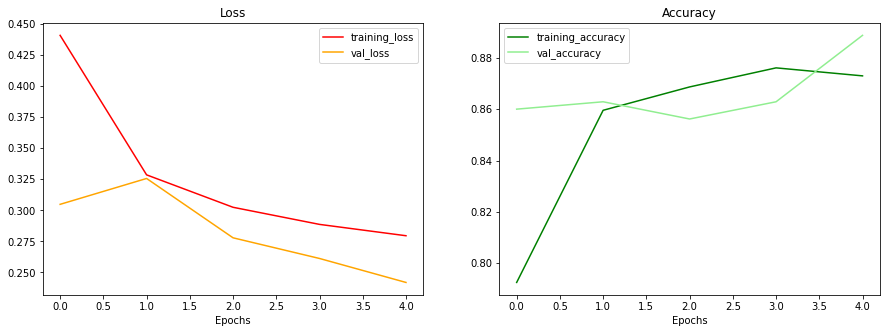

In [ ]:
plot_loss_curves(history_8)
evaluate_model(model_8, test_data)
make_val_predictions(model_8, class_names)

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_9 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_9.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_9 = model_9.fit(train_data_augmented,
                        epochs=10,
                        validation_data=val_data_augmented) # fraction of the training data to be used as validation data

Epoch 1/10
131/131 [==============================] - 116s 879ms/step - loss: 0.4379 - accuracy: 0.7906 - val_loss: 0.3136 - val_accuracy: 0.8485
Epoch 2/10
131/131 [==============================] - 114s 873ms/step - loss: 0.3192 - accuracy: 0.8557 - val_loss: 0.3498 - val_accuracy: 0.8658
Epoch 3/10
131/131 [==============================] - 116s 883ms/step - loss: 0.2935 - accuracy: 0.8737 - val_loss: 0.3053 - val_accuracy: 0.8236
Epoch 4/10
131/131 [==============================] - 114s 870ms/step - loss: 0.2875 - accuracy: 0.8730 - val_loss: 0.2456 - val_accuracy: 0.9060
Epoch 5/10
131/131 [==============================] - 113s 860ms/step - loss: 0.2625 - accuracy: 0.8890 - val_loss: 0.2366 - val_accuracy: 0.8907
Epoch 6/10
131/131 [==============================] - 113s 861ms/step - loss: 0.2717 - accuracy: 0.8852 - val_loss: 0.2588 - val_accuracy: 0.8955
Epoch 7/10
131/131 [==============================] - 108s 821ms/step - loss: 0.2778 - accuracy: 0.8785 - val_loss: 0.2694 -

Model loss 0.4
Model accuracy 84.6%
Found 16 images belonging to 2 classes.


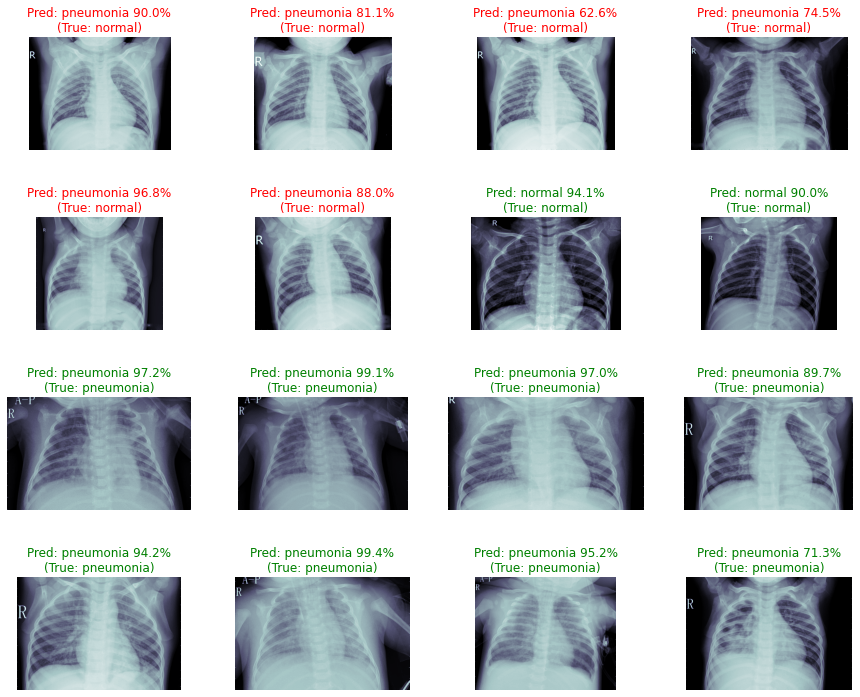

In [ ]:
plot_loss_curves(history_9)
evaluate_model(model_9, test_data)
make_val_predictions(model_9, class_names)

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_10 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
model_10.compile(loss='binary_crossentropy', # binary since we are working with 2 classes (0 & 1)
                optimizer=Adam(),
                metrics='accuracy')


# Fit the model
history_10 = model_10.fit(train_data_augmented,
                        epochs=30,
                        validation_data=val_data_augmented) # fraction of the training data to be used as validation data

Epoch 1/30
131/131 [==============================] - 113s 854ms/step - loss: 0.4544 - accuracy: 0.7755 - val_loss: 0.3492 - val_accuracy: 0.8284
Epoch 2/30
131/131 [==============================] - 113s 862ms/step - loss: 0.3267 - accuracy: 0.8526 - val_loss: 0.3055 - val_accuracy: 0.8706
Epoch 3/30
131/131 [==============================] - 114s 874ms/step - loss: 0.2957 - accuracy: 0.8704 - val_loss: 0.3181 - val_accuracy: 0.8265
Epoch 4/30
131/131 [==============================] - 113s 868ms/step - loss: 0.2942 - accuracy: 0.8713 - val_loss: 0.2934 - val_accuracy: 0.8773
Epoch 5/30
131/131 [==============================] - 113s 860ms/step - loss: 0.2737 - accuracy: 0.8804 - val_loss: 0.2794 - val_accuracy: 0.8849
Epoch 6/30
131/131 [==============================] - 114s 868ms/step - loss: 0.2698 - accuracy: 0.8871 - val_loss: 0.3889 - val_accuracy: 0.8102
Epoch 7/30
131/131 [==============================] - 113s 866ms/step - loss: 0.2792 - accuracy: 0.8766 - val_loss: 0.2693 -

In [ ]:
plot_loss_curves(history_10)
evaluate_model(model_10, test_data)
make_val_predictions(model_10, class_names)

Model loss 0.4
Model accuracy 82.5%
Found 16 images belonging to 2 classes.


### Deeper Evaluation

In [ ]:
y_pred = model_9.predict(test_data)
y_pred = np.round(y_pred.flatten())

In [ ]:
print(f'Accuracy: {accuracy_score(test_data.labels, y_pred):.1%}')
print(f"Precision: {precision_score(test_data.labels, y_pred):.1%}")
print(f"Recall: {recall_score(test_data.labels, y_pred):.1%}")
print(f"F1: {f1_score(test_data.labels, y_pred):.1%}")

Accuracy: 84.6%
Precision: 83.6%
Recall: 93.8%
F1: 88.4%


In [ ]:
cm = confusion_matrix(test_data.labels, y_pred)

In [20]:
def plot_confusion_matrix(cm):
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))

  sns.heatmap(data=cm, ax=ax[0], cmap='RdYlGn', annot=True, fmt='.0f', annot_kws={'size': 16})
  ax[0].set_title('Confusion Matrix', fontsize=22)
  ax[0].set_xlabel('Predicted Label', fontsize=16)
  ax[0].set_ylabel('True Label', fontsize=16)
  ax[0].set_xticks(ticks=np.arange(.5,len(class_names)+.5))
  ax[0].set_xticklabels(labels=class_names, fontsize=12)
  ax[0].set_yticks(ticks=np.arange(.5,len(class_names)+.5))
  ax[0].set_yticklabels(labels=class_names, fontsize=12)

  sns.heatmap(data=cm/np.sum(cm, axis=1, keepdims=True), ax=ax[1], cmap='RdYlGn', annot=True, fmt='.1%', annot_kws={'size': 16})
  ax[1].set_title('Confusion Matrix', fontsize=22)
  ax[1].set_xlabel('Predicted Label', fontsize=16)
  ax[1].set_ylabel('True Label', fontsize=16)
  ax[1].set_xticks(ticks=np.arange(.5,len(class_names)+.5))
  ax[1].set_xticklabels(labels=class_names, fontsize=12)
  ax[1].set_yticks(ticks=np.arange(.5,len(class_names)+.5))
  ax[1].set_yticklabels(labels=class_names, fontsize=12)

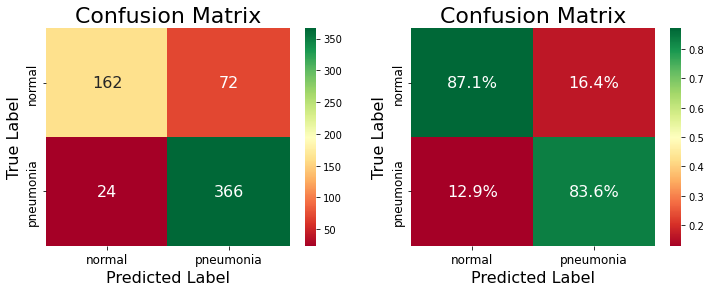

In [ ]:
plot_confusion_matrix(cm)

# Zoidberg 2.0 - Multi-class Classification

## Notebook Config

In [1]:
DATASET_DIR = "/content/zoidberg-2.0/chest_Xray_multi"
SEED = 2
IMG_SIZE = 224, 224
BATCH_SIZE = 32

In [2]:
import os
import pathlib
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Load data

In [3]:
!git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

Cloning into 'zoidberg-2.0'...
remote: Enumerating objects: 5916, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 5916 (delta 5), reused 10 (delta 1), pack-reused 5902
Receiving objects: 100% (5916/5916), 1.14 GiB | 16.70 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (11712/11712), done.


## Inspect data

In [4]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(DATASET_DIR):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_multi'.
There are 2 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_multi/val'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_multi/val/normal'.
There are 0 directories and 8 images in '/content/zoidberg-2.0/chest_Xray_multi/val/bacteria'.
There are 3 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_multi/test'.
There are 0 directories and 234 images in '/content/zoidberg-2.0/chest_Xray_multi/test/normal'.
There are 0 directories and 242 images in '/content/zoidberg-2.0/chest_Xray_multi/test/bacteria'.
There are 0 directories and 148 images in '/content/zoidberg-2.0/chest_Xray_multi/test/virus'.
There are 3 directories and 0 images in '/content/zoidberg-2.0/chest_Xray_multi/train'.
There are 0 directories and 1341 images in '/content/zoidberg-2.0/chest_Xray_multi/train/normal'.
There are 0 directories and 2530 images in '/content/zoidberg-2.0/chest_Xray_multi

In [5]:
train_dir = f"{DATASET_DIR}/train/"
val_dir = f"{DATASET_DIR}/val/"
test_dir = f"{DATASET_DIR}/test/"

In [6]:
# Get the class names for our multi-class dataset
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['bacteria' 'normal' 'virus']


In [10]:
# View a random image from the training dataset
img = view_random_images(target_dir=train_dir,
                         class_names=class_names)

## Preprocess Data

In [11]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True, # flip the image on the horizontal axis
                                             validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255.) 

# Turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                                                   target_size=IMG_SIZE,
                                                                   class_mode='categorical',
                                                                   batch_size=BATCH_SIZE,
                                                                   shuffle=True,
                                                                   seed=SEED,
                                                                   subset='training')

val_data_augmented = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                                                 target_size=IMG_SIZE,
                                                                 class_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=True,
                                                                 seed=SEED,
                                                                 subset='validation')

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=SEED)

Found 4173 images belonging to 3 classes.
Found 1043 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


## Train best model so far

In [ ]:
# Set random seed
tf.random.set_seed(SEED)

# Create the model
model_11 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(len(class_names), activation='softmax')
])

# Compile the model
model_11.compile(loss='categorical_crossentropy',
                 optimizer=Adam(),
                 metrics=['accuracy'])


# Fit the model
history_11 = model_11.fit(train_data_augmented,
                          epochs=10,
                          validation_data=val_data_augmented) # fraction of the training data to be used as validation data

Epoch 1/10
131/131 [==============================] - 367s 3s/step - loss: 0.9272 - accuracy: 0.5622 - val_loss: 0.8635 - val_accuracy: 0.5666
Epoch 2/10
131/131 [==============================] - 357s 3s/step - loss: 0.7797 - accuracy: 0.6552 - val_loss: 0.8669 - val_accuracy: 0.6366
Epoch 3/10
131/131 [==============================] - 357s 3s/step - loss: 0.7419 - accuracy: 0.6695 - val_loss: 0.7636 - val_accuracy: 0.6769
Epoch 4/10
131/131 [==============================] - 352s 3s/step - loss: 0.7138 - accuracy: 0.6930 - val_loss: 0.7468 - val_accuracy: 0.6759
Epoch 5/10
131/131 [==============================] - 353s 3s/step - loss: 0.7006 - accuracy: 0.7024 - val_loss: 0.8074 - val_accuracy: 0.6376
Epoch 6/10
131/131 [==============================] - 351s 3s/step - loss: 0.6892 - accuracy: 0.7009 - val_loss: 0.7781 - val_accuracy: 0.6654
Epoch 7/10
131/131 [==============================] - 350s 3s/step - loss: 0.6695 - accuracy: 0.7148 - val_loss: 0.7036 - val_accuracy: 0.6913

## Evaluate model

In [ ]:
plot_loss_curves(history_11)
# evaluate_model(model_11, test_data)
# make_val_predictions(model_11, class_names)

In [12]:
def evaluate_model_multi(model, test_data):
  y_pred = model.predict(test_data)
  y_pred = y_pred.argmax(axis=1)
  print(f'Accuracy: {accuracy_score(test_data.labels, y_pred):.1%}')
  print(f"Precision: {precision_score(test_data.labels, y_pred, average='weighted'):.1%}")
  print(f"Recall: {recall_score(test_data.labels, y_pred, average='weighted'):.1%}")
  print(f"F1: {f1_score(test_data.labels, y_pred, average='weighted'):.1%}")

  cm = confusion_matrix(test_data.labels, y_pred)
  plot_confusion_matrix(cm)
  

Accuracy: 72.8%
Precision: 74.2%
Recall: 72.8%
F1: 71.2%


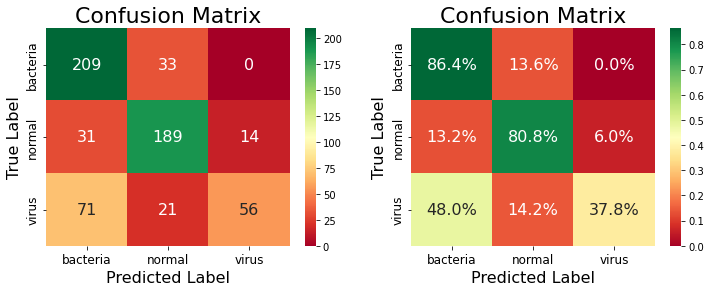

In [ ]:
evaluate_model_multi(model_11, test_data)

# Transfer Learning

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [14]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [15]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# New: EfficientNetB0 feature vector (version 2)
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [16]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SIZE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

## ResNet 50 V2

In [26]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_augmented.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [27]:
# Fit the model
resnet_history = resnet_model.fit(train_data_augmented,
                                  epochs=10,
                                  validation_data=val_data_augmented,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220411-055847
Epoch 1/10
131/131 [==============================] - 128s 943ms/step - loss: 0.6901 - accuracy: 0.7002 - val_loss: 0.6238 - val_accuracy: 0.7306
Epoch 2/10
131/131 [==============================] - 126s 960ms/step - loss: 0.5776 - accuracy: 0.7572 - val_loss: 0.6194 - val_accuracy: 0.7287
Epoch 3/10
131/131 [==============================] - 120s 913ms/step - loss: 0.5220 - accuracy: 0.7855 - val_loss: 0.6227 - val_accuracy: 0.7057
Epoch 4/10
131/131 [==============================] - 119s 909ms/step - loss: 0.4932 - accuracy: 0.7973 - val_loss: 0.5417 - val_accuracy: 0.7546
Epoch 5/10
131/131 [==============================] - 117s 897ms/step - loss: 0.4992 - accuracy: 0.7910 - val_loss: 0.5676 - val_accuracy: 0.7411
Epoch 6/10
131/131 [==============================] - 117s 895ms/step - loss: 0.4915 - accuracy: 0.7937 - val_loss: 0.5706 - val_accuracy: 0.7507
Epoch 7/10
131/131 [=============================

Accuracy: 82.9%
Precision: 83.6%
Recall: 82.9%
F1: 82.4%


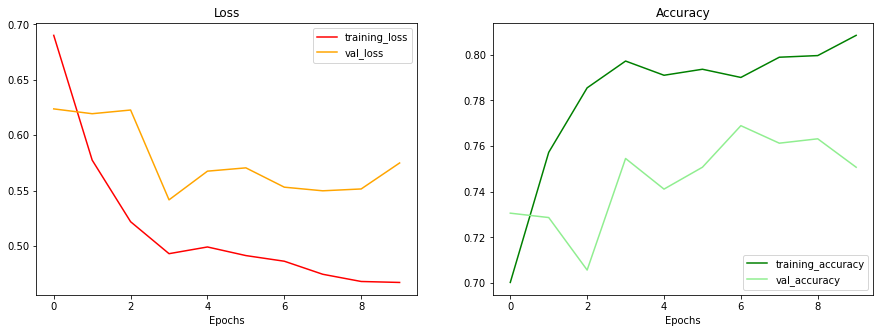

In [28]:
plot_loss_curves(resnet_history)
evaluate_model_multi(resnet_model, test_data)

EfficientNet B0 V2

In [29]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_augmented.num_classes)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_augmented,
                                  epochs=10,
                                  validation_data=val_data_augmented,
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnetB0V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0V2/20220411-061920
Epoch 1/10
131/131 [==============================] - 124s 886ms/step - loss: 0.7197 - accuracy: 0.6966 - val_loss: 0.6421 - val_accuracy: 0.7296
Epoch 2/10
131/131 [==============================] - 117s 893ms/step - loss: 0.5862 - accuracy: 0.7532 - val_loss: 0.5830 - val_accuracy: 0.7383
Epoch 3/10
131/131 [==============================] - 119s 907ms/step - loss: 0.5489 - accuracy: 0.7740 - val_loss: 0.5897 - val_accuracy: 0.7555
Epoch 4/10
131/131 [==============================] - 118s 900ms/step - loss: 0.5376 - accuracy: 0.7738 - val_loss: 0.5811 - val_accuracy: 0.7526
Epoch 5/10
131/131 [==============================] - 118s 902ms/step - loss: 0.5254 - accuracy: 0.7848 - val_loss: 0.5643 - val_accuracy: 0.7565
Epoch 6/10
131/131 [==============================] - 117s 897ms/step - loss: 0.5158 - accuracy: 0.7882 - val_loss: 0.5576 - val_accuracy: 0.7641
Epoch 7/10
131/131 [=======================

Accuracy: 85.3%
Precision: 85.3%
Recall: 85.3%
F1: 85.0%


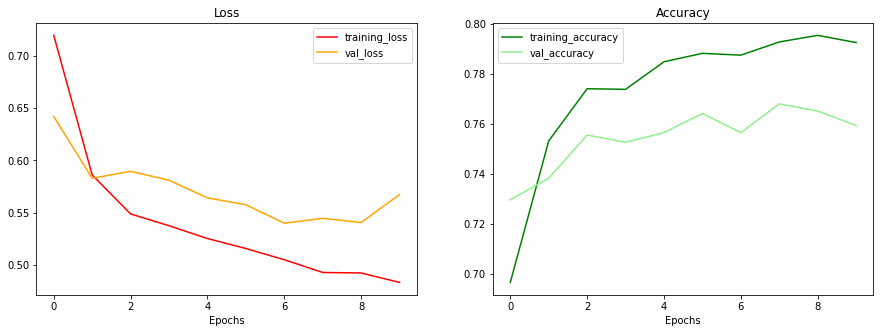

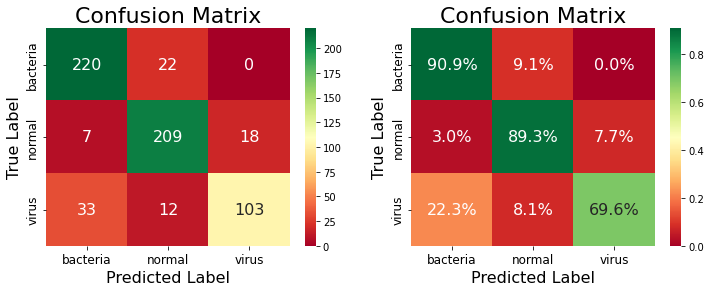

In [30]:
plot_loss_curves(efficientnet_history)
evaluate_model_multi(efficientnet_model, test_data)

In [31]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0V2 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=e0GGDJO02CU15PKR9Rgv3OgfkDfbvi&prompt=consent&access_type=off

In [32]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/4rn3RjYwQbO7xZdYs9Iorg/
	Name                 EfficientNetB0V2 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures
	Id                   4rn3RjYwQbO7xZdYs9Iorg
	Created              2022-04-11 06:40:32 (4 minutes ago)
	Updated              2022-04-11 06:40:38 (4 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              180
	Tensor bytes         0
	Binary object bytes  8752548
Total: 1 experiment(s)
